# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# import libraries
import numpy as np
import os
import datetime
import os
import keras
from skimage import io
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
from collections import Counter 
import cv2

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [4]:
# we started with batch size = 663 and slowly optimised it to fit into our resources 
batch_size = 30 #experiment with the batch size
frames = 30 #number of frames in each video 
# we start with 120*120 images and adjust these later for model building process
rows = 120 # final image height to be decided
cols = 120 # final image width to be decided
channels = 3
step_size = 1 #this will help in customising the frames chosen from the video for model building

In [5]:
# we distribute the images on the basis of size. This is just done for experiment puroposes later.
# outpaths = [train_path] #val_path
def image_segregation(path='train'):
    final_120 =[]
    final_360=[]
    doc = ''
    if(path=='train'):
        op = 'Project_data/train/'
        doc = train_doc
    else:
        op = 'Project_data/val/'
        doc = val_doc
    for f in doc:
        path = f.split(';')[0]
        imgs = os.listdir(op+path)
        for img in imgs:
            image = io.imread(op+path+'/'+img)
            if(image.shape[0]==360):
                final_120.append(op+path+'/'+img) 

            if(image.shape[0]==120):
                final_360.append(op+path+'/'+img)
    return (final_120, final_360)


In [6]:
make list of images with corresponding sizes
final_120, final_360 = image_segregation()

In [7]:
view random imagees
selectedIndexes  = []
for i in range(3):
    selectedIndexes.append(rn.randint(0,5520))


s_im_120 = [final_120[i] for i in selectedIndexes]
s_im_360 = [final_360[i] for i in selectedIndexes]
print(s_im_120)
print(s_im_360)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
# we have looked at random images from the set and decided the following dimensions for the images. This has helped to 
# remove the edges and preserve the center of the image where gesture data is present. 
def cropImage(image):
    (image_h, image_w, _) = image.shape
    print(image.shape)
    h_start=0
    h_end = image_h
    w_start=0
    w_end = image_w
    # for images 120*160
    if(image_h==120):
        h_start=20
        w_start=10
        w_end = 120
    # for images of size 360*360
    elif image_h==360:
        h_start=30
        w_start=30
        w_end = 320
    return image[h_start:h_end, w_start:w_end]

In [9]:
# this method will adjust the size of the image to given dimensions. The appropriate size will be found through experments.
def resize_image(image, height=rows, width=cols):
    return  resize(image, (height, width),anti_aliasing=False)

In [10]:
# we try different normalization technique
def normalize_image(image):
    norm_image = image - np.min(image)/np.max(image) - np.min(image)
#     norm_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
    return norm_image

In [11]:
#utility to show processed images
def showImage(array, idx):
    a = array[idx]
    image = io.imread(a)
    plt.subplot(2, 2,1)
    plt.imshow(image)

    cropped = cropImage(image)
    plt.subplot(2,2,2)
    plt.imshow(cropped)

    resized = resize_image(cropped)
    plt.subplot(2, 2,3)
    plt.imshow(resized)

    
    normalized = normalize_image(resized)
    plt.subplot(2, 2,4)
    plt.imshow(normalized)

    plt.show()

In [12]:
#plt.figure(figsize=(300,300))
#showImage(s_im_360, 0)

In [13]:
# view random images
#plt.figure(figsize=(300,300))
#showImage(s_im_120, 0)

In [14]:
# Helper function to generate a random affine transform on the iamge
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return M

In [15]:
# Helper function to initialize all the batch image data and labels
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, frames, rows, cols, channels)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [16]:
# internal function to generate augmented data. 
# We have done 2 types of augmentation to prevent overfitting of data- flipping of the images and affine transformation. 
def fetch_aug_batchdata(source_path, folder_list, batch_num, batch_size, t,validation):
    
    batch_data,batch_labels = init_batch_data(batch_size)
    
    # We will also build an augumented batch data with affine transformation
    batch_data_aug,batch_labels_aug = init_batch_data(batch_size)
    
    # We will also build an augmented batch data with horizontal flip
    batch_data_flip,batch_labels_flip = init_batch_data(batch_size)
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0, frames)] 

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        M = get_random_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            ## image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Cropping non symmetric frames
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes   
            resized = cv2.resize(image, (rows, cols), interpolation = cv2.INTER_AREA)
            #Normal data
            batch_data[folder,idx] = (resized)
            
            #Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
            
            # Data with horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
        else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final

In [18]:
# wrapper generator function. it supports ablation experiment and a flag to decide between training and validation folder
def generator(source_path, folder_list, batch_size, validation=False,ablation=None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    if(ablation!=None):
        folder_list=folder_list[:ablation]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do

            yield fetch_aug_batchdata(source_path, folder_list, batch, batch_size, t,validation)
        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield fetch_aug_batchdata(source_path, folder_list, batch, batch_size, t,validation)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [19]:
# path to images folders
train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

classes= 5 # output classes

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [20]:
# function to plot performance of model
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [21]:
# keras related imports
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, ZeroPadding3D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

## LSTM Model

### Model 1

In [22]:
# we have decided to experiment with this optimizer first. So keeping it in common place
optimiser = optimizers.Adam(0.001) 

In [23]:
feature_map=[8, 16, 32, 64, 128] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5]
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [24]:
#write your model here
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [25]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 7, 7, 64)      0         
__________

In [26]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [27]:
train_generator = generator(train_path, train_doc, batch_size,validation=True) # validation=True just prevents the augmentation of data
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [28]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 10
Epoch 1/10
 Project_data/val ; batch size = 10
67/67 [==============================] - 193s 3s/step - loss: 1.3517 - categorical_accuracy: 0.4204 - val_loss: 1.2241 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 1.22408, saving model to model_init_lstm_2020-11-0811_02_37.269104/model-00001-1.35592-0.41780-1.22408-0.51000.h5
Epoch 2/10
67/67 [==============================] - 47s 699ms/step - loss: 1.2850 - categorical_accuracy: 0.4925 - val_loss: 1.4767 - val_categorical_accuracy: 0.4600

Epoch 00002: val_loss did not improve from 1.22408
Epoch 3/10
67/67 [==============================] - 47s 708ms/step - loss: 1.3040 - categorical_accuracy: 0.5025 - val_loss: 1.4456 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss did not improve from 1.22408
Epoch 4/10
67/67 [==============================] - 45s 670ms/step - loss: 1.2247 - categorical_accuracy: 0.5224 - val_loss: 1.3635 - val

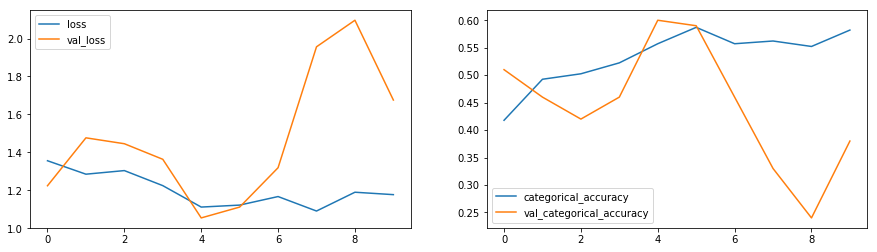

In [30]:
plot(model_history)

NameError: name 'a' is not defined

### Model 1.b

#### We augment the data

In [ ]:
#write your model here
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [ ]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Model 2

#### We add batch normalization

In [ ]:
feature_map=[8, 16, 32, 64, 128] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5]
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [ ]:
#write your model here
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))


model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [ ]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Model 3

#### We reduce the dense layer neurons

In [ ]:
feature_map=[8, 16, 32, 64, 128] 
dense_layer_size = [256,128,5] # we reduce the dense layer neurons
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [ ]:

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

# model.add(keras.layers.Dropout(0.4))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# model.add(keras.layers.Dropout(0.4))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [ ]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Model 4

#### We increase learning rate

In [ ]:
feature_map=[8, 16, 32, 64, 128] 
dense_layer_size = [256,128,5] # we reduce the dense layer neurons
num_epochs = 10
batch_size = 10
input_shape = (frames, rows, cols, channels)

In [ ]:

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [ ]:
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
# timestamp to use in model name. 
curr_dt_time = datetime.datetime.now()

model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

## GRU MODEL

In [ ]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5] # 
classes= 5
input_shape = (frames, rows, cols, channels)
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
batch_size = 10
num_epochs = 10
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Removing dropout layers

In [ ]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5] # 
classes= 5
input_shape = (frames, rows, cols, channels)
model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [ ]:
optimiser = optimizers.Adam(0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### change image size to 84X84

In [ ]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000,500,5] # 
classes= 5
rows = 84
cols = 84

input_shape = (frames, rows, cols, channels)

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [ ]:
optimiser = optimizers.Adam(0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Adding one more dense layer

In [ ]:
 # reset image size to 120*120
rows = 120
cols = 120

In [ ]:
#write your model here
feature_map=[8, 16, 32, 64, 128, 256] # we will expirment with different number of features for different layers
dense_layer_size = [1000, 500, 250, 5] # 
classes= 5

input_shape = (frames, rows, cols, channels)

model = Sequential()
# add multiple convulation layers
model.add(TimeDistributed(Conv2D(feature_map[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(feature_map[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(feature_map[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(feature_map[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_layer_size[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_layer_size[2], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [ ]:
optimiser = optimizers.Adam(0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
model_name = 'model_init_CNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  callbacks=callbacks_list, validation_data=val_generator, 
                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

## Conv3D model

### Optimiser SGD

In [ ]:
filters = [8,16,32,64]
dense = [256, 128, 5]

# Input
input_shape=(frames, rows, cols, channels)

# Define model
model = Sequential()

model.add(Conv3D(filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(dense[2], activation='softmax'))

In [ ]:
optimiser = optimizers.SGD() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [ ]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 10
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Increased Epochs and Adam optimiser

In [ ]:
filters = [8,16,32,64]
dense = [256, 128, 5]

# Input
input_shape=(frames, rows, cols, channels)

# Define model
model = Sequential()

model.add(Conv3D(filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(dense[2], activation='softmax'))

In [ ]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [ ]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Increasing dense perceptrons

In [ ]:
classes= 5
input_shape = (frames, rows, cols, channels)

nb_filters = [8,16,32,64]
nb_dense = [1000, 500, 5]

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [ ]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Adding one extra layer with dropout

In [ ]:
classes= 5
input_shape = (frames, rows, cols, channels)

nb_filters = [8, 16, 32, 64, 128]
nb_dense = [1000, 500, 5]

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[4], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [ ]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)

### Adding one more layer with BatchNormalization

In [ ]:
classes= 5
input_shape = (frames, rows, cols, channels)

nb_filters = [8, 16, 32, 64, 128, 256]
nb_dense = [1000, 500, 5]

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[4], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[5], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [ ]:
model_name = 'model_init_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
batch_size = 10
num_epochs = 20
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(model_history)